# Classification Using Time Window with Memory

In [17]:
import pandas as pd
import numpy as np
np.random.seed(0)
import statsmodels as sm
import matplotlib.pyplot as plt
% matplotlib inline
import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import seaborn as sns 
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import preprocessing
import pandas.tseries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas import Series

In [2]:
#Read in crypto currency data into a pandas dataframe
ticker_df = pd.read_csv('bitmex_BTCUSD_candles_5m_price_2.csv.gz')
ticker_df.head()

,Unnamed: 0,Date,Open,Close,High,Low,Trades,Volume,Y
0,0,2018-01-01T00:00:00.000Z,13838.5,13873.0,13961.0,13838.0,958,2041363,0
1,1,2018-01-01T00:05:00.000Z,13873.0,13800.0,13920.0,13800.0,1151,2595550,0
2,2,2018-01-01T00:10:00.000Z,13800.0,13771.5,13800.5,13675.0,1859,5809735,0
3,3,2018-01-01T00:15:00.000Z,13771.5,13769.0,13795.0,13711.0,861,1816360,0
4,4,2018-01-01T00:20:00.000Z,13769.0,13702.0,13775.5,13596.0,1235,4967912,0


In [3]:
#get general description of dataset
ticker_df.describe()

,Unnamed: 0,Open,Close,High,Low,Trades,Volume,Y
count,192212.000000,192212.000000,192212.000000,192212.000000,192212.000000,192212.000000,1.922120e+05,192212.000000
mean,96105.500000,7401.913192,7401.889247,7412.207854,7391.249123,1944.652425,8.578252e+06,0.534998
std,55486.969308,2635.049532,2635.011953,2642.212963,2627.488476,2015.694428,1.277001e+07,0.498775
min,0.000000,3129.500000,3129.500000,3137.000000,3121.000000,0.000000,0.000000e+00,0.000000
25%,48052.750000,5529.500000,5529.500000,5534.000000,5525.500000,738.000000,2.245409e+06,0.000000
50%,96105.500000,7282.500000,7282.500000,7291.000000,7274.500000,1367.000000,4.771472e+06,1.000000
75%,144158.250000,9255.000000,9255.000000,9270.000000,9242.000000,2406.000000,9.820680e+06,1.000000
max,192211.000000,17412.000000,17412.000000,17422.000000,17242.000000,38740.000000,3.369836e+08,1.000000


In [4]:
#check for correlations between variables
corr_df = ticker_df.corr()
corr_df

,Unnamed: 0,Open,Close,High,Low,Trades,Volume,Y
Unnamed: 0,1.000000,-0.089199,-0.089172,-0.090224,-0.088216,0.210293,0.070957,0.005820
Open,-0.089199,1.000000,0.999958,0.999971,0.999966,0.157322,0.158251,-0.050264
Close,-0.089172,0.999958,1.000000,0.999975,0.999975,0.157081,0.157802,-0.050735
High,-0.090224,0.999971,0.999975,1.000000,0.999942,0.159907,0.160905,-0.050594
Low,-0.088216,0.999966,0.999975,0.999942,1.000000,0.154089,0.154627,-0.050492
Trades,0.210293,0.157322,0.157081,0.159907,0.154089,1.000000,0.921336,-0.033592
Volume,0.070957,0.158251,0.157802,0.160905,0.154627,0.921336,1.000000,-0.025094
Y,0.005820,-0.050264,-0.050735,-0.050594,-0.050492,-0.033592,-0.025094,1.000000


In [5]:
#drop unnamed column
ticker_df.drop("Unnamed: 0", inplace = True, axis = 1)
ticker_df.head()

,Date,Open,Close,High,Low,Trades,Volume,Y
0,2018-01-01T00:00:00.000Z,13838.5,13873.0,13961.0,13838.0,958,2041363,0
1,2018-01-01T00:05:00.000Z,13873.0,13800.0,13920.0,13800.0,1151,2595550,0
2,2018-01-01T00:10:00.000Z,13800.0,13771.5,13800.5,13675.0,1859,5809735,0
3,2018-01-01T00:15:00.000Z,13771.5,13769.0,13795.0,13711.0,861,1816360,0
4,2018-01-01T00:20:00.000Z,13769.0,13702.0,13775.5,13596.0,1235,4967912,0


In [6]:
#Change Date column datatype to timestamp
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'], infer_datetime_format=True)

In [7]:
#set dataframe index to the Date column
ticker_df.set_index('Date', inplace = True)
ticker_df.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:05:00',
               '2018-01-01 00:10:00', '2018-01-01 00:15:00',
               '2018-01-01 00:20:00', '2018-01-01 00:25:00',
               '2018-01-01 00:30:00', '2018-01-01 00:35:00',
               '2018-01-01 00:40:00', '2018-01-01 00:45:00',
               ...
               '2019-10-30 08:50:00', '2019-10-30 08:55:00',
               '2019-10-30 09:00:00', '2019-10-30 09:05:00',
               '2019-10-30 09:10:00', '2019-10-30 09:15:00',
               '2019-10-30 09:20:00', '2019-10-30 09:25:00',
               '2019-10-30 09:30:00', '2019-10-30 09:35:00'],
              dtype='datetime64[ns]', name='Date', length=192212, freq=None)

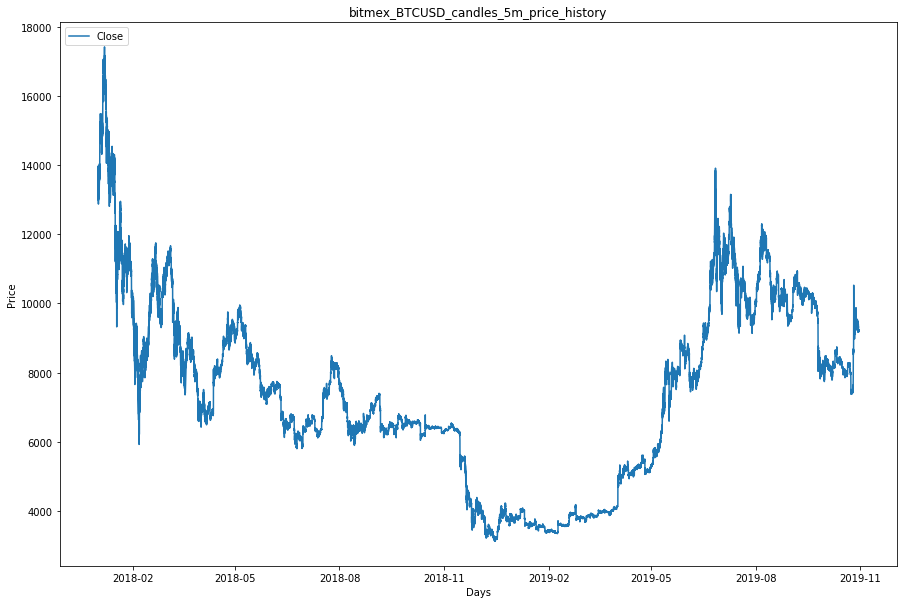

In [8]:
plt.figure(figsize=(15,10))
plt.plot(ticker_df["Close"])
plt.title('bitmex_BTCUSD_candles_5m_price_history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Close'], loc='upper left')
plt.show()

In [20]:
ticker = ticker_df.drop('Y', axis = 1)

In [138]:
#normalize data
normalized_df = (ticker - ticker.min())/(ticker.max()- ticker.min())
normalized_df['Y'] = ticker_df["Y"]

In [23]:
open_ = normalized_df['Open'].values
high_ = normalized_df['High'].values
low_ = normalized_df['Low'].values
close_ = normalized_df['Close'].values

### Check for Stationarity - Augmented Dickey-Fuller Test (ADF)

In [24]:
result = adfuller(open_)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.513384
p-value: 0.112252
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [25]:
result1 = adfuller(close_)
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
print('Critical Values:')
for key, value in result1[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.509513
p-value: 0.113177
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [26]:
result2 = adfuller(low_)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.518165
p-value: 0.111117
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [27]:
result3 = adfuller(high_)
print('ADF Statistic: %f' % result3[0])
print('p-value: %f' % result3[1])
print('Critical Values:')
for key, value in result3[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.463506
p-value: 0.124608
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


From a comparison of all the test statistics with their respective critical values at 5% alpha it is evident that each of the series is non-stationary. Our next step will be to make them stationary using a difference transform

In [28]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [29]:
# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [32]:
#Detrend Open prices
diff_trend_open = difference(open_)

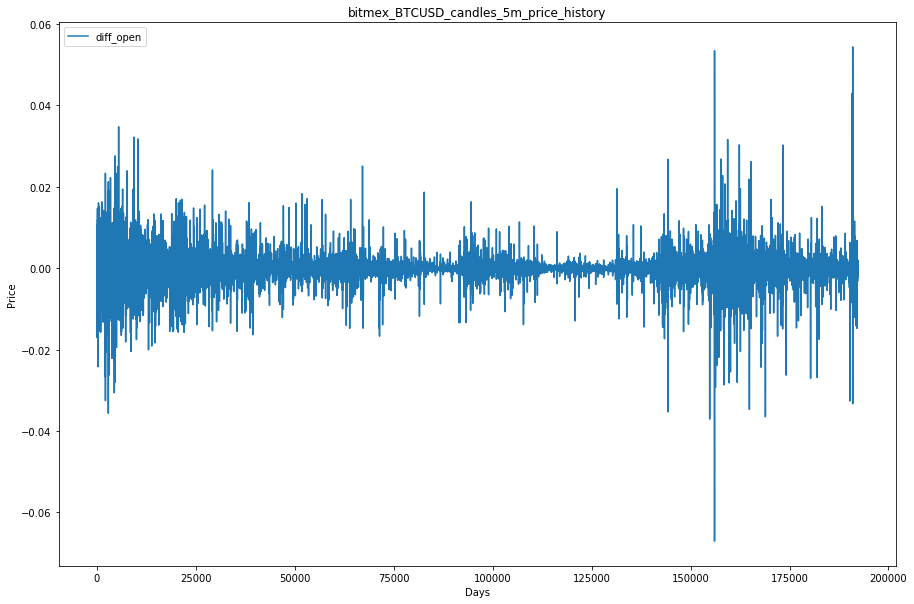

In [33]:
plt.figure(figsize=(15,10))
plt.plot(diff_open)
plt.title('bitmex_BTCUSD_candles_5m_price_history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['diff_open'], loc='upper left')
plt.show()

The trend has now been removed. Seasonality still exists evidenced by the wildly swinging volatility. The next step will be to remove the seasonality.

In [87]:
#De-season Open Prices
diff_season_open = difference(diff_trend_open, 90000)

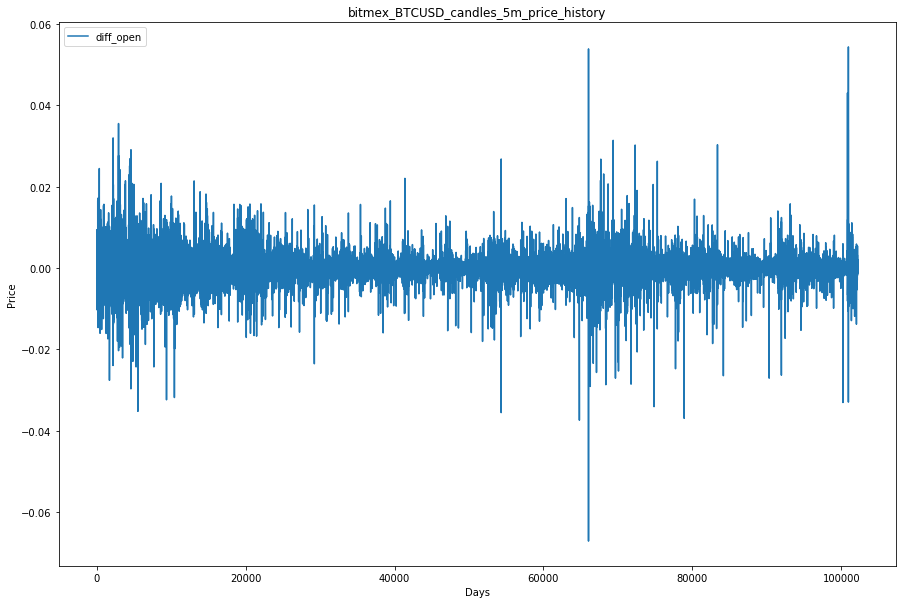

In [88]:
plt.figure(figsize=(15,10))
plt.plot(diff_season_open)
plt.title('bitmex_BTCUSD_candles_5m_price_history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['diff_open'], loc='upper left')
plt.show()

In [89]:
#Detrend low prices
diff_trend_low = difference(low_)

In [91]:
#De-season low Prices
diff_season_low = difference(diff_trend_low, 90000)

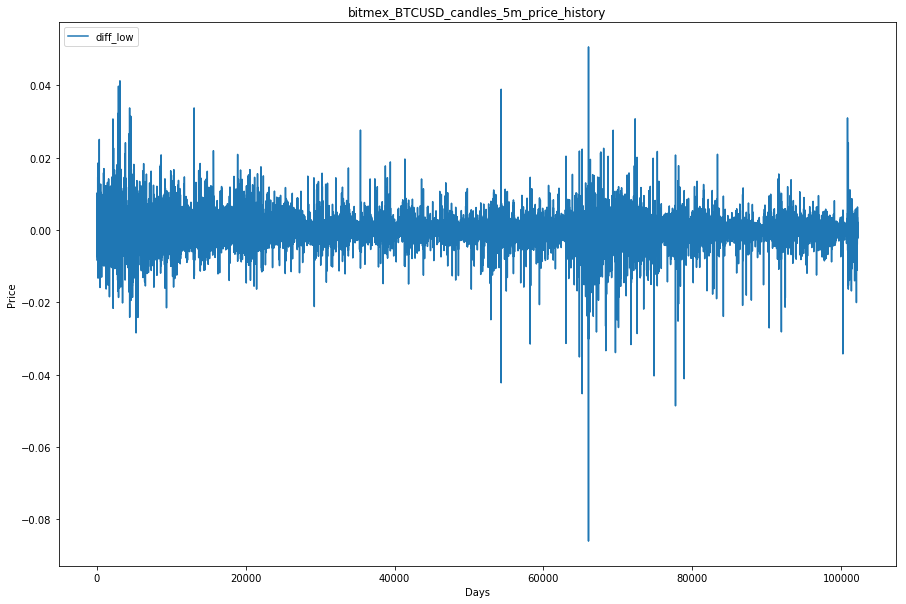

In [92]:
plt.figure(figsize=(15,10))
plt.plot(diff_season_low)
plt.title('bitmex_BTCUSD_candles_5m_price_history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['diff_low'], loc='upper left')
plt.show()

In [93]:
#Detrend high prices
diff_trend_high = difference(high_)

In [94]:
#De-season low Prices
diff_season_high = difference(diff_trend_high, 90000)

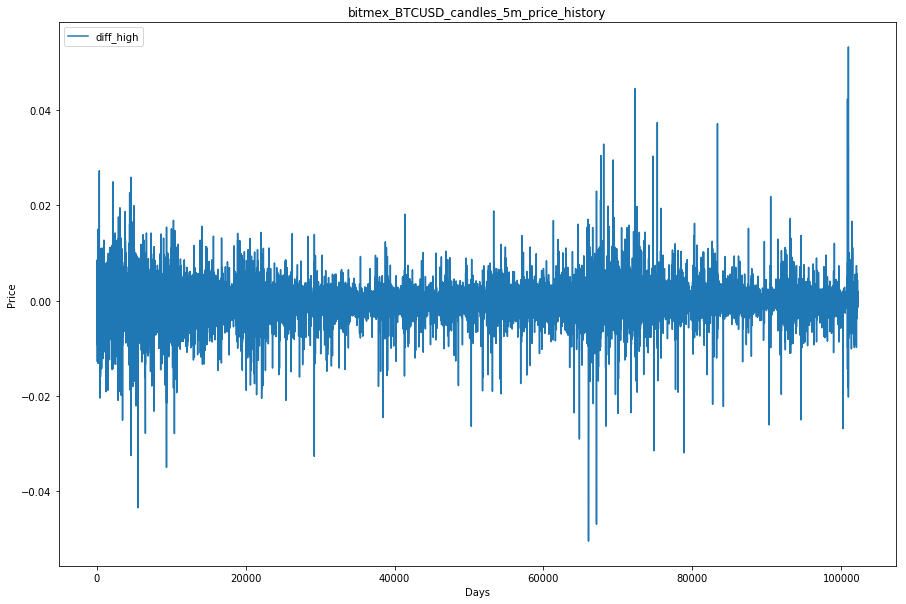

In [95]:
plt.figure(figsize=(15,10))
plt.plot(diff_season_high)
plt.title('bitmex_BTCUSD_candles_5m_price_history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['diff_high'], loc='upper left')
plt.show()

In [96]:
#Detrend close prices
diff_trend_close = difference(close_)

In [118]:
#De-season low Prices
diff_season_close = difference(diff_trend_close, 90000)

In [119]:
type(diff_season_close)

pandas.core.series.Series

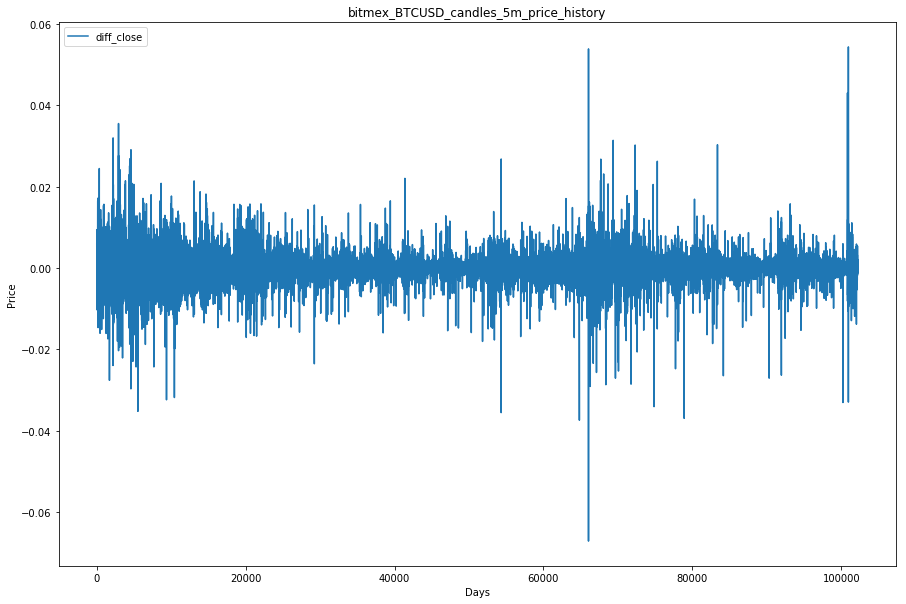

In [99]:
plt.figure(figsize=(15,10))
plt.plot(diff_season_close)
plt.title('bitmex_BTCUSD_candles_5m_price_history')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['diff_close'], loc='upper left')
plt.show()

In [120]:
stationary_df = pd.concat([diff_season_open, diff_season_low, diff_season_high, diff_season_close],names =['diff_season_open', 'diff_season_low', 'diff_season_high', 'diff_season_close'])

In [127]:
stationary_df1 = pd.DataFrame(data = dict(diff_season_open= diff_season_open, diff_season_low= diff_season_low,
                              diff_season_high= diff_season_high, diff_season_close= diff_season_close))

In [140]:
stationary_df1.shape

(102211, 4)

In [141]:
normalized_df = normalized_df.iloc[90001:]
normalized_df.shape

(102211, 7)

In [145]:
stationary_df = stationary_df1
stationary_df.set_index(normalized_df.index, inplace = True)
stationary_df['Y'] = normalized_df['Y']
stationary_df.head()

,diff_season_open,diff_season_low,diff_season_high,diff_season_close,Y
Date,,,,,
2018-11-09 12:05:00,-0.002591,0.002691,0.003430,0.005881,0
2018-11-09 12:10:00,0.005881,0.009454,0.008365,0.001855,0
2018-11-09 12:15:00,0.001855,-0.002549,0.000245,0.000140,1
2018-11-09 12:20:00,0.000140,0.008144,0.001400,0.004761,1
2018-11-09 12:25:00,0.004761,-0.002797,0.004445,0.000175,1


In [146]:
stationary_df.shape

(102211, 5)

In [231]:
ticker_np = stationary_df.values
train_size = int(len(ticker_np)*0.6)
val_size = int(len(ticker_np)*0.3) + train_size
train= ticker_np[0:train_size]
val = ticker_np[train_size: val_size]
test = ticker_np[val_size: len(ticker_np)]
print('Observations: %d' % (len(stationary_df)))
print('Training Observations: %d' % (len(train)))
print('Validation Observations: %d' % (len(val)))
print('Testing Observations: %d' % (len(test)))

Observations: 102211
Training Observations: 61326
Validation Observations: 30663
Testing Observations: 10222


In [232]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan= True):
    """This function takes in univariate or multivariate time series data and transforms it
    to a supervised machine learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X). Default is 1
        n_out: Number of observations as output (y). Default is 1
        dropnan: Boolean whether or not to drop rows with NaN values. Default is True
    Returns:
        Pandas DataFrame of series framed for supervised learning."""
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
    

In [233]:
#Transform training set to supervised machine learning dataset
new_train = series_to_supervised(train, 3, 1)

In [234]:
new_train.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,-0.002591,0.002691,0.003430,0.005881,0.0,0.005881,0.009454,0.008365,0.001855,0.0,0.001855,-0.002549,0.000245,0.000140,1.0,0.000140,0.008144,0.001400,0.004761,1.0
4,0.005881,0.009454,0.008365,0.001855,0.0,0.001855,-0.002549,0.000245,0.000140,1.0,0.000140,0.008144,0.001400,0.004761,1.0,0.004761,-0.002797,0.004445,0.000175,1.0
5,0.001855,-0.002549,0.000245,0.000140,1.0,0.000140,0.008144,0.001400,0.004761,1.0,0.004761,-0.002797,0.004445,0.000175,1.0,0.000175,-0.003435,-0.004725,-0.001470,1.0
6,0.000140,0.008144,0.001400,0.004761,1.0,0.004761,-0.002797,0.004445,0.000175,1.0,0.000175,-0.003435,-0.004725,-0.001470,1.0,-0.001470,-0.001806,0.000525,0.000035,0.0
7,0.004761,-0.002797,0.004445,0.000175,1.0,0.000175,-0.003435,-0.004725,-0.001470,1.0,-0.001470,-0.001806,0.000525,0.000035,0.0,0.000035,0.003824,0.001645,-0.000210,1.0


In [235]:
#Drop irrelevant columns
new_train.drop(columns = ['var1(t)','var2(t)','var3(t)','var4(t)'], inplace = True)

In [236]:
new_train.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
3,-0.002591,0.002691,0.003430,0.005881,0.0,0.005881,0.009454,0.008365,0.001855,0.0,0.001855,-0.002549,0.000245,0.000140,1.0,1.0
4,0.005881,0.009454,0.008365,0.001855,0.0,0.001855,-0.002549,0.000245,0.000140,1.0,0.000140,0.008144,0.001400,0.004761,1.0,1.0
5,0.001855,-0.002549,0.000245,0.000140,1.0,0.000140,0.008144,0.001400,0.004761,1.0,0.004761,-0.002797,0.004445,0.000175,1.0,1.0
6,0.000140,0.008144,0.001400,0.004761,1.0,0.004761,-0.002797,0.004445,0.000175,1.0,0.000175,-0.003435,-0.004725,-0.001470,1.0,0.0
7,0.004761,-0.002797,0.004445,0.000175,1.0,0.000175,-0.003435,-0.004725,-0.001470,1.0,-0.001470,-0.001806,0.000525,0.000035,0.0,1.0


In [237]:
#Split training data into target and input variables
y_train = new_train['var5(t)']
X_train = new_train.drop('var5(t)', axis = 1)

In [238]:
#Transform Validation set to supervised machine learning dataset and drop irrelevant columns
new_val = series_to_supervised(val, 3, 1)
new_val.drop(columns = ['var1(t)','var2(t)','var3(t)','var4(t)'], inplace = True)

In [239]:
#Split validation data into target and input variables
y_val = new_val['var5(t)']
X_val = new_val.drop('var5(t)', axis = 1)

In [240]:
new_val.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t)
3,-0.004096,-0.002620,0.002345,-0.000105,0.0,-0.000105,-0.000354,-0.001645,-0.000525,1.0,-0.000525,0.000460,0.001995,0.002241,0.0,0.0
4,-0.000105,-0.000354,-0.001645,-0.000525,1.0,-0.000525,0.000460,0.001995,0.002241,0.0,0.002241,0.000212,0.001785,-0.000945,0.0,1.0
5,-0.000525,0.000460,0.001995,0.002241,0.0,0.002241,0.000212,0.001785,-0.000945,0.0,-0.000945,-0.000248,-0.002205,-0.000840,1.0,0.0
6,0.002241,0.000212,0.001785,-0.000945,0.0,-0.000945,-0.000248,-0.002205,-0.000840,1.0,-0.000840,-0.000673,0.000700,0.000455,0.0,1.0
7,-0.000945,-0.000248,-0.002205,-0.000840,1.0,-0.000840,-0.000673,0.000700,0.000455,0.0,0.000455,-0.001416,0.000105,-0.001715,1.0,1.0


In [241]:
#Transform test set to supervised machine learning dataset and drop irrelevant columns
new_test = series_to_supervised(test, 3, 1)
new_test.drop(columns = ['var1(t)','var2(t)','var3(t)','var4(t)'], inplace = True)

In [242]:
#Split data data into target and input variables
y_test = new_test['var5(t)']
X_test = new_test.drop('var5(t)', axis = 1)

# Random Forrest Classifier

In [161]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [163]:
rfc = RandomForestClassifier(n_estimators = 200,random_state = 101)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

In [164]:
#Training Accuracy
forrest_training_accuracy = rfc.score(X_train, y_train)
print('Training Accuracy: %.2f%%' % (forrest_training_accuracy*100.0))

Training Accuracy: 100.00%


In [165]:
#Validation Accuracy
forrest_validation_accuracy = rfc.score(X_val, y_val)
print('Validation Accuracy: %.2f%%' % (forrest_validation_accuracy*100.0))

Validation Accuracy: 51.44%


From the above training and validation metrics we can see that the model is overfitting the training data. This means that generalization cannot occur. We will now move into the hyperparameter tuning stage.

In [166]:
#Testing Accuracy
forrest_testing_accuracy = rfc.score(X_test, y_test)
print('Validation Accuracy: %.2f%%' % (forrest_testing_accuracy*100.0))

Validation Accuracy: 52.66%


# Logistic Regression

In [167]:
log_clf = LogisticRegression()
log_clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [168]:
#Training Accuracy
log_training_accuracy = log_clf.score(X_train, y_train)
print('Training Accuracy: %.2f%%' % (log_training_accuracy*100.0))

Training Accuracy: 54.88%


In [169]:
#Validation Accuracy
log_validation_accuracy = log_clf.score(X_val, y_val)
print('Validation Accuracy: %.2f%%' % (log_validation_accuracy*100.0))

Validation Accuracy: 50.37%


In [170]:
#Testing Accuracy
log_testing_accuracy = log_clf.score(X_test, y_test)
print('Validation Accuracy: %.2f%%' % (log_testing_accuracy*100.0))

Validation Accuracy: 51.59%


# AdaBoost Classifier

In [171]:
adaboost_clf = AdaBoostClassifier()
adaboost_mean_cv_score = np.mean(cross_val_score(adaboost_clf, X_train, y_train, cv=3))

adaboost_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1]
}

In [172]:
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(X_train, y_train)

print("Training Accuracy: {:.4}%".format(adaboost_grid_search.best_score_ * 100))
print("")
print("Optimal Parameters: {}".format(adaboost_grid_search.best_params_))

Training Accuracy: 54.85%

Optimal Parameters: {'learning_rate': 0.1, 'n_estimators': 50}


In [175]:
#Training Accuracy
ada_training_accuracy = adaboost_grid_search.score(X_train, y_train)
print('Training Accuracy: %.2f%%' % (ada_training_accuracy*100.0))

Training Accuracy: 54.99%


In [176]:
#Validation Accuracy
ada_validation_accuracy = adaboost_grid_search.score(X_val, y_val)
print('Validation Accuracy: %.2f%%' % (ada_validation_accuracy*100.0))

Validation Accuracy: 50.33%


In [178]:
#Testing Accuracy
ada_testing_accuracy = adaboost_grid_search.score(X_test, y_test)
print('Testing Accuracy: %.2f%%' % (ada_testing_accuracy*100.0))

Testing Accuracy: 51.64%


# XGBoost Classifier

In [179]:
import xgboost as xgb

In [180]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6, 15],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [181]:
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: Th

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 10
n_estimators: 30
subsample: 0.7


In [186]:
#Training Accuracy
training_accuracy = grid_clf.score(X_train, y_train)
print('Training Accuracy: %.2f%%' % (training_accuracy*100.0))

Training Accuracy: 57.80%


/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [187]:
#Validation Accuracy
validation_accuracy = grid_clf.score(X_val, y_val)
print('Validation Accuracy: %.2f%%' % (validation_accuracy*100.0))

Validation Accuracy: 51.32%


/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [188]:
#Testing Accuracy
testing_accuracy = grid_clf.score(X_test, y_test)
print('Testing Accuracy: %.2f%%' % (testing_accuracy*100.0))

Testing Accuracy: 52.32%


/Users/shachiakyaagba/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Long Short Term Memory Classifier (LSTM)

In [243]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [244]:
# choose a number of time steps
n_steps = 10
n_features = 4

In [245]:
# convert training data into input/output
X, y = split_sequences(train, n_steps)
print(X.shape, y.shape)

(61317, 10, 4) (61317,)


In [246]:
# convert validation data into input/output
val_input, val_target = split_sequences(val, n_steps)
print(val_input.shape, val_target.shape)

(30654, 10, 4) (30654,)


In [247]:
# convert testing data into input/output
test_input, test_target = split_sequences(test, n_steps)
print(test_input.shape, test_target.shape)

(10213, 10, 4) (10213,)


In [248]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [249]:

# define model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.3))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])


In [250]:
# fit model
history = model.fit(X, y, epochs=800, verbose=1, batch_size=None, validation_data = (val_input, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Train on 61317 samples, validate on 30654 samples
Epoch 1/800
61317/61317 [==============================] - 28s 450us/step - loss: 0.6873 - acc: 0.5556 - val_loss: 0.6973 - val_acc: 0.5049
Epoch 2/800
61317/61317 [==============================] - 26s 418us/step - loss: 0.6870 - acc: 0.5557 - val_loss: 0.6993 - val_acc: 0.5049
Epoch 3/800
61317/61317 [==============================] - 26s 419us/step - loss: 0.6871 - acc: 0.5557 - val_loss: 0.6981 - val_acc: 0.5049
Epoch 4/800
61317/61317 [==============================] - 26s 425us/step - loss: 0.6870 - acc: 0.5557 - val_loss: 0.6996 - val_acc: 0.5049
Epoch 5/800
61317/61317 [==============================] - 26s 422us/step - loss: 0.6870 - acc: 0.5557 - val_loss: 0.6974 - val_acc: 0.5049
Epoch 6/800
61317/61317 [==============================] - 26s 420us/step - loss: 0.6870 - acc: 0.5557 - val_loss: 0.6982 - val_acc: 0.5049
Epoch 7/800
42432/61317 [===================>..........] - ETA: 7s - loss: 0.6863 - acc: 0.5585

KeyboardInterrupt: 

# Artificial Neural Network (ANN)

In [251]:
dnn = Sequential()
dnn.add(Dense(100, activation = 'relu'))
dnn.add(Dropout(0.4))
dnn.add(Dense(150, activation = 'tanh'))
dnn.add(Dropout(0.4))
dnn.add(Dense(1, activation = 'sigmoid'))
dnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
dnn_history = dnn.fit(X_train.values, y_train.values, epochs = 150, verbose = 2, batch_size = 32, validation_data = (X_val, y_val))
plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Train on 61323 samples, validate on 30660 samples
Epoch 1/150
 - 5s - loss: 0.6868 - acc: 0.5556 - val_loss: 0.6932 - val_acc: 0.5050
Epoch 2/150
 - 5s - loss: 0.6866 - acc: 0.5555 - val_loss: 0.6955 - val_acc: 0.5050
Epoch 3/150
 - 5s - loss: 0.6868 - acc: 0.5557 - val_loss: 0.6965 - val_acc: 0.5050
Epoch 4/150
 - 5s - loss: 0.6866 - acc: 0.5557 - val_loss: 0.6979 - val_acc: 0.5050
Epoch 5/150
 - 5s - loss: 0.6866 - acc: 0.5556 - val_loss: 0.6978 - val_acc: 0.5050
Epoch 6/150
 - 6s - loss: 0.6867 - acc: 0.5556 - val_loss: 0.6988 - val_acc: 0.5050
Epoch 7/150
 - 5s - loss: 0.6866 - acc: 0.5556 - val_loss: 0.6963 - val_acc: 0.5050
Epoch 8/150
 - 6s - loss: 0.6866 - acc: 0.5557 - val_loss: 0.6956 - val_acc: 0.5050
Epoch 9/150
 - 5s - loss: 0.6866 - acc: 0.5557 - val_loss: 0.6956 - val_acc: 0.5050
Epoch 10/150
 - 5s - loss: 0.6866 - acc: 0.5554 - val_loss: 0.6979 - val_acc: 0.5050
Epoch 11/150
 - 5s - loss: 0.6866 - acc: 0.5552 - val_loss: 0.6965 - val_acc: 0.5050
Epoch 12/150
 - 5s - los

In [321]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

AUC: 0.5165949588566855


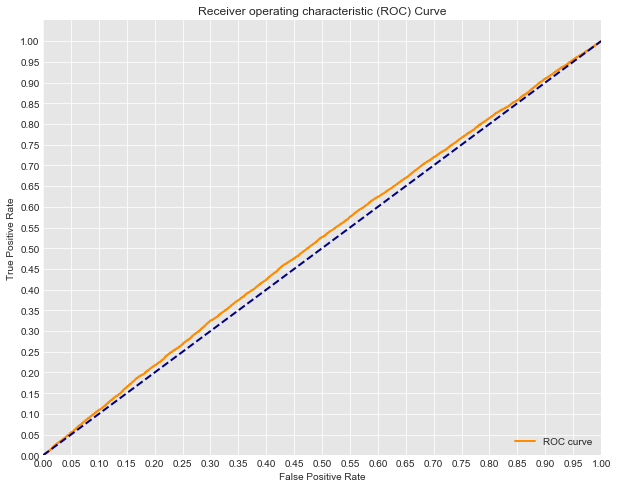

In [104]:
#Initial Model
logreg = LogisticRegression(fit_intercept = False)

#Probability scores for val set
y_score = logreg.fit(X_train, y_train).decision_function(X_val)
#False positive Rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_val, y_score)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix

In [105]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[   57    60]
 [18638 19680]]


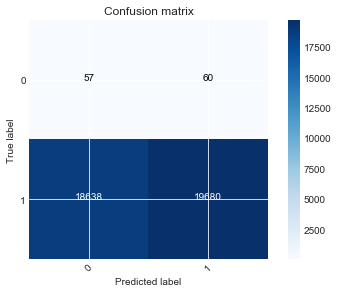

In [106]:
y_hat_val = logreg.predict(X_val)
cnf_matrix = confusion_matrix(y_hat_val, y_val)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

This baseline model gives us an AUC of just over 50%. My next step is to go back to my correlation matrix and eliminate variables that are highly correlated.

In [108]:
corr_df

,Open,Close,High,Low,Trades,Volume,Y
Open,1.000000,0.999958,0.999971,0.999966,0.157322,0.158251,-0.050264
Close,0.999958,1.000000,0.999975,0.999975,0.157081,0.157802,-0.050735
High,0.999971,0.999975,1.000000,0.999942,0.159907,0.160905,-0.050594
Low,0.999966,0.999975,0.999942,1.000000,0.154089,0.154627,-0.050492
Trades,0.157322,0.157081,0.159907,0.154089,1.000000,0.921336,-0.033592
Volume,0.158251,0.157802,0.160905,0.154627,0.921336,1.000000,-0.025094
Y,-0.050264,-0.050735,-0.050594,-0.050492,-0.033592,-0.025094,1.000000


In [113]:
independent_df = normalized_df[['Open', 'Volume']]


In [112]:
#Split dataset into training set, validation set and testing set
X_train = independent_df[:134525]
X_val = independent_df[134526:172961]
X_test = independent_df[172962:]
y_train = y[:134525]
y_val = y[134526:172961]
y_test = y[172962:]

LogisticRegression(C=0.001, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC for 0.001: 0.5005885253955338
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
AUC for 0.01: 0.5096320635769687
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
AUC for 0.1: 0.5105587805959961
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scal

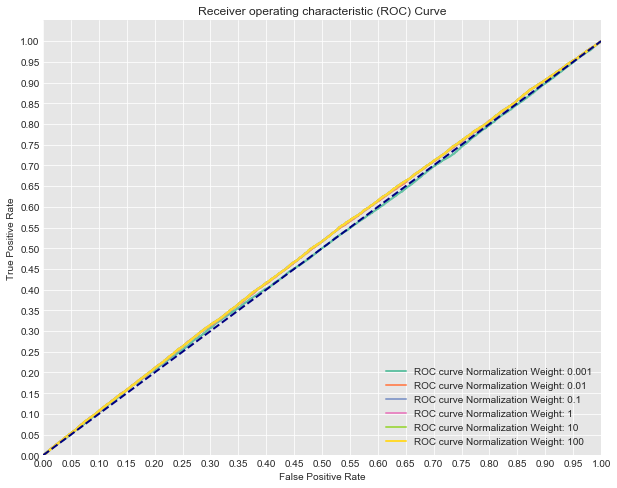

In [116]:
C_param_range = [0.001,0.01,0.1,1,10,100]
names = [0.001,0.01,0.1,1,10,100]
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_val = logreg.predict(X_val)

    y_score = logreg.fit(X_train, y_train).decision_function(X_val)

    fpr, tpr, thresholds = roc_curve(y_val, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()